In [1]:
# %reset
import numpy as np
import sys,os
import readgadget
import MAS_library as MASL
import pickle as pk
import readfof
import matplotlib

import matplotlib.pyplot as pl
pl.rc('text', usetex=True)
# Palatino
pl.rc('font', family='DejaVu Sans')
%matplotlib inline



%load_ext Cython

# # This routine computes the density field and save results to file
# def compute_df(snapshot, ptypes, grid, fout):
#     # if not(os.path.exists(snapshot+'.0')) and not(os.path.exists(snapshot+'.0.hdf5')):
#         # return 0
#     print(snapshot)
#     df = MASL.density_field_gadget(snapshot, ptypes, grid, MAS='CIC',
#                                    do_RSD=False, axis=0, verbose=True)
#     df = df/np.mean(df, dtype=np.float64)-1.0
#     np.save(fout, df)
    

    
    


In [2]:
# !pip install Pylians --upgrade


In [3]:
%load_ext Cython


The Cython extension is already loaded. To reload it, use:
  %reload_ext Cython


In [4]:
%%cython

cimport numpy as np
cpdef void NGP_mass(np.float32_t[:,:] pos, np.float32_t[:] logM, np.float32_t[:,:,:,:] gridM, float BoxSize):

    cdef int axis,dims,coord,nMmax,jM
    cdef long i,particles
    cdef float inv_cell_size
    cdef int index[3]

    # find number of particles, the inverse of the cell size and dims
    particles = pos.shape[0];  coord = pos.shape[1];  dims = gridM.shape[0]; nMmax = gridM.shape[3]
    inv_cell_size = dims/BoxSize

    # when computing things in 2D, use the index[2]=0 plane
    for i in range(3):  index[i] = 0

    # do a loop over all particles
    for i in range(particles):
        for axis in range(coord):
            index[axis] = <int>(pos[i,axis]*inv_cell_size + 0.5)
            index[axis] = (index[axis]+dims)%dims
        for jM in range(nMmax):
            if gridM[index[0],index[1],index[2], jM] == 0:
                gridM[index[0],index[1],index[2], jM] = logM[i]
                break
            else:
                pass
        
        
        

In file included from /mnt/home/spandey/miniconda3/envs/nbodykit/lib/python3.8/site-packages/numpy/core/include/numpy/ndarraytypes.h:1960,
                 from /mnt/home/spandey/miniconda3/envs/nbodykit/lib/python3.8/site-packages/numpy/core/include/numpy/ndarrayobject.h:12,
                 from /mnt/home/spandey/miniconda3/envs/nbodykit/lib/python3.8/site-packages/numpy/core/include/numpy/arrayobject.h:5,
                 from /dev/shm/.cache-spandey/ipython/cython/_cython_magic_7e2340aded3958b7067615d379fe3e22.c:773:
/mnt/home/spandey/miniconda3/envs/nbodykit/lib/python3.8/site-packages/numpy/core/include/numpy/npy_1_7_deprecated_api.h:17:2: warning: #warning "Using deprecated NumPy API, disable it with " "#define NPY_NO_DEPRECATED_API NPY_1_7_API_VERSION" [-Wcpp]
   17 | #warning "Using deprecated NumPy API, disable it with " \
      |  ^~~~~~~


In [5]:
# NGP_mass()


In [6]:
# boxsize = 1000.0
# for jb in range(8):
#     # indsel = (coords[:,0] > (jb%2)*boxsize/2) & (coords[:,0] < ((jb%2)+1)*boxsize/2) & (coords[:,1] > ((jb//2)%2)*boxsize/2) & (coords[:,1] < (((jb//2)%2)+1)*boxsize/2) & (coords[:,2] > (jb//4)*boxsize/2) & (coords[:,2] < ((jb//4)+1)*boxsize/2)
#     print((jb%2)*boxsize/2,  ((jb%2)+1)*boxsize/2)
#     print(((jb//2)%2)*boxsize/2,  (((jb//2)%2)+1)*boxsize/2)
#     print((jb//4)*boxsize/2,((jb//4)+1)*boxsize/2)
#     print('\n')



In [7]:
# import jax.numpy as jnp
# # %env XLA_PYTHON_CLIENT_PREALLOCATE=false
# # %env XLA_PYTHON_CLIENT_MEM_FRACTION=.99
# import sys, os
# os.environ['XLA_PYTHON_CLIENT_PREALLOCATE'] = 'False'
# os.environ['XLA_PYTHON_CLIENT_MEM_FRACTION'] = '.99'


# def get_index(i, j, k, Ngrid):
#     """ Generate 1D index. """

#     return (i % Ngrid) + ((j % Ngrid) * Ngrid) + ((k % Ngrid) * Ngrid * Ngrid)

# def cic(coords, boxsize, Ngrid, ndim):
#     # Create a new grid which will contain the densities
#     grid = jnp.zeros(Ngrid ** ndim, dtype=jnp.float32)

#     # Bin coords into their cells and find distance to cell centre.
#     x_c = jnp.floor(coords[:, 0] * Ngrid / boxsize).astype(int)
#     y_c = jnp.floor(coords[:, 1] * Ngrid / boxsize).astype(int)
#     z_c = jnp.floor(coords[:, 2] * Ngrid / boxsize).astype(int)

#     # Distance to center of cell
#     d_x = coords[:, 0] * Ngrid / boxsize - (x_c + 0.5)
#     d_y = coords[:, 1] * Ngrid / boxsize - (y_c + 0.5)
#     d_z = coords[:, 2] * Ngrid / boxsize - (z_c + 0.5)

#     # Which side of the center is this particle on
#     inc_x = jnp.where(d_x < 0, -1, 1)
#     inc_y = jnp.where(d_y < 0, -1, 1)
#     inc_z = jnp.where(d_z < 0, -1, 1)

#     # Work with absolute values.
#     d_x = jnp.abs(d_x).astype(jnp.float64)
#     d_y = jnp.abs(d_y).astype(jnp.float64)
#     d_z = jnp.abs(d_z).astype(jnp.float64)

#     t_x = 1. - d_x
#     t_y = 1. - d_y
#     t_z = 1. - d_z

#     # Add contributions to 8 cells
#     idx = get_index(x_c, y_c, z_c, Ngrid)
#     grid += jnp.bincount(idx, minlength=Ngrid ** ndim, weights=t_x * t_y * t_z)

#     idx = get_index(x_c + inc_x, y_c, z_c, Ngrid)
#     grid += jnp.bincount(idx, minlength=Ngrid ** ndim, weights=d_x * t_y * t_z)

#     idx = get_index(x_c, y_c + inc_y, z_c, Ngrid)
#     grid += jnp.bincount(idx, minlength=Ngrid ** ndim, weights=t_x * d_y * t_z)

#     idx = get_index(x_c, y_c, z_c + inc_z, Ngrid)
#     grid += jnp.bincount(idx, minlength=Ngrid ** ndim, weights=t_x * t_y * d_z)

#     idx = get_index(x_c + inc_x, y_c + inc_y, z_c, Ngrid)
#     grid += jnp.bincount(idx, minlength=Ngrid ** ndim, weights=d_x * d_y * t_z)

#     idx = get_index(x_c, y_c + inc_y, z_c + inc_z, Ngrid)
#     grid += jnp.bincount(idx, minlength=Ngrid ** ndim, weights=t_x * d_y * d_z)

#     idx = get_index(x_c + inc_x, y_c, z_c + inc_z, Ngrid)
#     grid += jnp.bincount(idx, minlength=Ngrid ** ndim, weights=d_x * t_y * d_z)

#     idx = get_index(x_c + inc_x, y_c + inc_y, z_c + inc_z, Ngrid)
#     grid += jnp.bincount(idx, minlength=Ngrid ** ndim, weights=d_x * d_y * d_z)

#     # TODO: Return overdensity instead of only the count
#     return grid.reshape(Ngrid, Ngrid, Ngrid, order='F')


# def cic_splitsuboxes(coords, boxsize, Ngrid, ndim):
#     # Create a new grid which will contain the densities
#     grid = jnp.zeros(Ngrid ** ndim, dtype=jnp.float32)
#     for jb in range(8):
#         indsel = (coords[:,0] > (jb%2)*boxsize/2) & (coords[:,0] < ((jb%2)+1)*boxsize/2) & (coords[:,1] > ((jb//2)%2)*boxsize/2) & (coords[:,1] < (((jb//2)%2)+1)*boxsize/2) & (coords[:,2] > (jb//4)*boxsize/2) & (coords[:,2] < ((jb//4)+1)*boxsize/2)

#         # Bin coords into their cells and find distance to cell centre.
#         x_c = jnp.floor(coords[indsel, 0] * Ngrid / boxsize).astype(int)
#         y_c = jnp.floor(coords[indsel, 1] * Ngrid / boxsize).astype(int)
#         z_c = jnp.floor(coords[indsel, 2] * Ngrid / boxsize).astype(int)

#         # Distance to center of cell
#         d_x = coords[indsel, 0] * Ngrid / boxsize - (x_c + 0.5)
#         d_y = coords[indsel, 1] * Ngrid / boxsize - (y_c + 0.5)
#         d_z = coords[indsel, 2] * Ngrid / boxsize - (z_c + 0.5)

#         # Which side of the center is this particle on
#         inc_x = jnp.where(d_x < 0, -1, 1)
#         inc_y = jnp.where(d_y < 0, -1, 1)
#         inc_z = jnp.where(d_z < 0, -1, 1)

#         # Work with absolute values.
#         d_x = jnp.abs(d_x).astype(jnp.float64)
#         d_y = jnp.abs(d_y).astype(jnp.float64)
#         d_z = jnp.abs(d_z).astype(jnp.float64)

#         t_x = 1. - d_x
#         t_y = 1. - d_y
#         t_z = 1. - d_z

#         # Add contributions to 8 cells
#         idx = get_index(x_c, y_c, z_c, Ngrid)
#         grid += jnp.bincount(idx, minlength=Ngrid ** ndim, weights=t_x * t_y * t_z)

#         idx = get_index(x_c + inc_x, y_c, z_c, Ngrid)
#         grid += jnp.bincount(idx, minlength=Ngrid ** ndim, weights=d_x * t_y * t_z)

#         idx = get_index(x_c, y_c + inc_y, z_c, Ngrid)
#         grid += jnp.bincount(idx, minlength=Ngrid ** ndim, weights=t_x * d_y * t_z)

#         idx = get_index(x_c, y_c, z_c + inc_z, Ngrid)
#         grid += jnp.bincount(idx, minlength=Ngrid ** ndim, weights=t_x * t_y * d_z)

#         idx = get_index(x_c + inc_x, y_c + inc_y, z_c, Ngrid)
#         grid += jnp.bincount(idx, minlength=Ngrid ** ndim, weights=d_x * d_y * t_z)

#         idx = get_index(x_c, y_c + inc_y, z_c + inc_z, Ngrid)
#         grid += jnp.bincount(idx, minlength=Ngrid ** ndim, weights=t_x * d_y * d_z)

#         idx = get_index(x_c + inc_x, y_c, z_c + inc_z, Ngrid)
#         grid += jnp.bincount(idx, minlength=Ngrid ** ndim, weights=d_x * t_y * d_z)

#         idx = get_index(x_c + inc_x, y_c + inc_y, z_c + inc_z, Ngrid)
#         grid += jnp.bincount(idx, minlength=Ngrid ** ndim, weights=d_x * d_y * d_z)

#         # TODO: Return overdensity instead of only the count
#     return grid.reshape(Ngrid, Ngrid, Ngrid, order='F')




In [ ]:
root = '/mnt/home/spandey/ceph/Quijote/fiducial_HR_new/Snapshots'
ji = 0
snapnum = 4
snapshot = '%s/%d/snapdir_%03d/snap_%03d'%(root,ji,snapnum,snapnum)
ptypes       = [1]
grid         = 128
BoxSize = 1000.0 #Mpc/h ; size of box
pos = readgadget.read_block(snapshot, "POS ", ptypes)/1e3 #positions in Mpc/h
# df_uniform_cic_jax = cic_splitsuboxes(jnp.array(pos), BoxSize, grid, 3)
# df_uniform_cic_jax = np.array(df_uniform_cic_jax/np.mean(df_uniform_cic_jax)-1.0)            




In [ ]:
velocity = readgadget.read_block(snapshot, "VEL", ptypes)/1e3 #positions in Mpc/h



In [ ]:
df_cic = np.zeros((grid,grid,grid), dtype=np.float32)
MASL.MA(np.float32(pos), df_cic, BoxSize, 'CIC', verbose=False)
df_pylians_cic = df_cic/np.mean(df_cic, dtype=np.float64)-1.0




In [ ]:
df_cic = MASL.density_field_gadget(snapshot, ptypes, grid, MAS='CIC',
                                do_RSD=False, axis=0, verbose=True)
df_pylians_cic = df_cic/np.mean(df_cic, dtype=np.float64)-1.0




In [ ]:
# df_Uniform_cic_jax
pl.figure()
pl.scatter(df_pylians_cic.flatten()[::100], df_uniform_cic_jax.flatten()[::100], s=0.1)



In [ ]:
pl.figure()
pl.subplot(121)
pl.imshow(df_pylians_cic[:,:,0], origin='lower')
pl.subplot(122)
pl.imshow(df_uniform_cic_jax[:,:,0], origin='lower')
# pl.colorbar()


In [6]:
# %pip install Pylians
import numpy as np
import sys,os
import readgadget
import MAS_library as MASL
import pickle as pk
import readfof
import matplotlib
from tqdm import tqdm
from nbodykit.source.catalog.file import BigFileCatalog
import nbodykit.lab as nb


In [7]:


root_in = '/mnt/home/fvillaescusa/ceph/Quijote/Snapshots/latin_hypercube_HR/'
ptypes       = [1]
root_out = '/mnt/home/spandey/ceph/Quijote/data_NGP_self_LH/'
grids         = [128]
BoxSize = 1000.0 #Mpc/h ; size of box
n_batch = 8
n_filter = 3
n_cnn_all = [0,4]
n_sim_array = np.arange(0,1100)
# snap_num_array = [4, 3, -1]
snap_num_array = [4, 3, -1]
BoxSize = 1000.0

for ji in tqdm(n_sim_array):
# for ji in tqdm(n_sim_array):
    # print('doing sim: ' + str(ji))
    # print('doing sim: ' + str(ji))
    for grid in grids:
        # print('doing res: ' + str(grid))
        for snapnum in snap_num_array:
            z = {4:0, 3:0.5, 2:1, 1:2, 0:3, -1: 127}[snapnum]

            # create output folder if it does not exists
            folder_out = '%s/%d'%(root_out,ji)
            if not(os.path.exists(folder_out)):
                os.system('mkdir %s'%folder_out)


            file_exists = True
            for n_cnn in n_cnn_all:
                # find name of output file
                savefname_density_subvol = '%s/density_HR_subvol_m_res_%d_z=%s_nbatch_%d_nfilter_%d_ncnn_%d.pk'%(folder_out,grid,z,n_batch,n_filter,n_cnn)
                savefname_density_full = '%s/density_HR_full_m_res_%d_z=%s_nbatch_%d_nfilter_%d_ncnn_%d.pk'%(folder_out,grid,z,n_batch,n_filter,n_cnn)
                # file_names_all.append(savefname_density_subvol)
                # file_names_all.append(savefname_density_full)
                if not(os.path.exists(savefname_density_subvol)):
                    file_exists = False
                    break
            
            # savefname_halos_subvol = '%s/halos_HR_subvol_res_%d_z=%s.pk'%(folder_out,grid,z)
            # savefname_halos_full = '%s/halos_HR_full_res_%d_z=%s.pk'%(folder_out,grid,z)            
            
            
            # savefname = folder_out  + '/halo_density_data_dict_' + str(grid) + '.pk'
            # if os.path.exists(fout):  continue

            # compute the density field and save it to file

            # pos = readgadget.read_block(snapshot, "POS ", ptypes)/1e3 #positions in Mpc/h
            # df_uniform_cic_jax = cic_splitsuboxes(jnp.array(pos), BoxSize, grid, 3)
            # df_uniform_cic_jax = np.array(df_uniform_cic_jax/np.mean(df_uniform_cic_jax)-1.0)            
            
            
            # df_ngp = MASL.density_field_gadget(snapshot, ptypes, grid, MAS='NGP',
            #                                do_RSD=False, axis=0, verbose=False)
            # df_pylians_ngp = df_ngp/np.mean(df_ngp, dtype=np.float64)-1.0            


            if not file_exists:
                if snapnum > 0:
                    snapshot = '%s/%d/snapdir_%03d/snap_%03d'%(root_in,ji,snapnum,snapnum)
                else:
                    snapshot = '%s/%d/ICs/ics' % (root_in, ji)
                df_cic = MASL.density_field_gadget(snapshot, ptypes, grid, MAS='CIC',
                                            do_RSD=False, axis=0, verbose=False)
                df_pylians_cic = df_cic/np.mean(df_cic, dtype=np.float64)-1.0

                print(ji)
                for n_cnn in n_cnn_all:
                    # find name of output file
                    savefname_density_subvol = '%s/density_HR_subvol_m_res_%d_z=%s_nbatch_%d_nfilter_%d_ncnn_%d.pk'%(folder_out,grid,z,n_batch,n_filter,n_cnn)
                    savefname_density_full = '%s/density_HR_full_m_res_%d_z=%s_nbatch_%d_nfilter_%d_ncnn_%d.pk'%(folder_out,grid,z,n_batch,n_filter,n_cnn)

                    n_dim_red = (n_filter - 1) // 2
                    n_pad = n_dim_red * n_cnn
                    if n_cnn > 0:
                        df_cic_pad = np.pad(df_pylians_cic, n_pad, 'wrap')
                        # df_uniform_cic_pad = np.pad(df_uniform_cic_jax, n_pad, 'wrap')
                        # df_ngp_pad = np.pad(df_pylians_ngp, n_pad, 'wrap')
                    else:
                        df_cic_pad = df_pylians_cic
                        # df_uniform_cic_pad = df_uniform_cic_jax
                        # df_ngp_pad = df_pylians_ngp

                    # we want to split the df_pad into n_batch^3 sub-cubes, but centered on the original df simulation box
                    xstart, ystart, zstart = n_pad, n_pad, n_pad
                    subvol_size = grid // n_batch + 2 * n_pad
                    nsubvol = n_batch**3
                    save_subvol_density_cic_pad = np.zeros((nsubvol, subvol_size, subvol_size, subvol_size))
                    # save_subvol_density_uniform_cic_pad = np.zeros((nsubvol, subvol_size, subvol_size, subvol_size))
                    # save_subvol_density_ngp_pad = np.zeros((nsubvol, subvol_size, subvol_size, subvol_size))
                    jc = 0
                    from tqdm import tqdm
                    for jx in (range(n_batch)):
                        for jy in range(n_batch):
                            for jz in range(n_batch):
                                # get the sub-cube
                                df_sub = df_cic_pad[xstart + jx * grid // n_batch - n_pad:xstart + (jx + 1) * grid // n_batch + n_pad,
                                                ystart + jy * grid // n_batch - n_pad:ystart + (jy + 1) * grid // n_batch + n_pad,
                                                zstart + jz * grid // n_batch - n_pad:zstart + (jz + 1) * grid // n_batch + n_pad]
                                # save the sub-cube
                                save_subvol_density_cic_pad[jc, ...] = df_sub


                                # df_sub = df_ngp_pad[xstart + jx * grid // n_batch - n_pad:xstart + (jx + 1) * grid // n_batch + n_pad,
                                #                 ystart + jy * grid // n_batch - n_pad:ystart + (jy + 1) * grid // n_batch + n_pad,
                                #                 zstart + jz * grid // n_batch - n_pad:zstart + (jz + 1) * grid // n_batch + n_pad]
                                # # save the sub-cube
                                # save_subvol_density_ngp_pad[jc, ...] = df_sub

                                jc += 1

                    subvol_size = grid // n_batch
                    nsubvol = n_batch**3
                    save_subvol_density_cic_unpad = np.zeros((nsubvol, subvol_size, subvol_size, subvol_size))
                    # save_subvol_density_uniform_cic_unpad = np.zeros((nsubvol, subvol_size, subvol_size, subvol_size))
                    save_subvol_density_ngp_unpad = np.zeros((nsubvol, subvol_size, subvol_size, subvol_size))
                    jc = 0
                    
                    for jx in (range(n_batch)):
                        for jy in range(n_batch):
                            for jz in range(n_batch):
                                # get the sub-cube
                                save_subvol_density_cic_unpad[jc] = df_pylians_cic[jx * subvol_size:(jx + 1) * subvol_size,
                                                            jy * subvol_size:(jy + 1) * subvol_size,
                                                            jz * subvol_size:(jz + 1) * subvol_size]
                                
                                # save_subvol_density_uniform_cic_unpad[jc] = df_uniform_cic_jax[jx * subvol_size:(jx + 1) * subvol_size,
                                #                                   jy * subvol_size:(jy + 1) * subvol_size,
                                #                                     jz * subvol_size:(jz + 1) * subvol_size]
                                
                                
                                # save_subvol_density_ngp_unpad[jc] = df_pylians_ngp[jx * subvol_size:(jx + 1) * subvol_size,
                                #                                jy * subvol_size:(jy + 1) * subvol_size,
                                #                                jz * subvol_size:(jz + 1) * subvol_size]                        
                                jc += 1


                    saved_density_subvol = {
                        'density_cic_pad':save_subvol_density_cic_pad,
                        # 'density_uniform_cic_pad':save_subvol_density_uniform_cic_pad,
                        # 'density_ngp_pad':save_subvol_density_ngp_pad,
                        'density_cic_unpad':save_subvol_density_cic_unpad,
                        # 'density_ngp_unpad':save_subvol_density_ngp_unpad,
                        # 'density_uniform_cic_unpad':save_subvol_density_uniform_cic_unpad
                        }                        

                    pk.dump(saved_density_subvol, open(savefname_density_subvol, 'wb'))

                    saved_density_full = {
                        'density_cic_unpad_combined':df_pylians_cic,
                        # 'density_uniform_cic_unpad_combined':df_uniform_cic_jax,
                        # 'density_ngp_unpad_combined':df_pylians_ngp,                                
                        'density_cic_pad_combined':df_cic_pad,
                        # 'density_ngp_pad_combined':df_ngp_pad,
                        # 'density_uniform_cic_pad_combined':df_uniform_cic_pad                                            
                        }                        

                    pk.dump(saved_density_full, open(savefname_density_full, 'wb'))




  1%|          | 11/1100 [00:00<00:10, 105.70it/s]

100%|██████████| 1100/1100 [00:09<00:00, 112.78it/s]


In [12]:
# %pip install Pylians
from tqdm import tqdm
# root         = '/pscratch/sd/s/spandey/quijote/Snapshot_fid'
# root = '/mnt/home/spandey/ceph/Quijote/fiducial_HR_new/Snapshots'
root = '/mnt/home/fvillaescusa/ceph/Quijote/Snapshots/latin_hypercube_HR'
# snap_dir_base='/pscratch/sd/s/spandey/quijote/Halos/fiducial'
snap_dir_base = '/mnt/home/fvillaescusa/ceph/Quijote/Halos/FoF/latin_hypercube_HR'
# root_out     = '/pscratch/sd/s/spandey/quijote/data_NGP_self'
root_out = '/mnt/home/spandey/ceph/Quijote/data_NGP_self_LH/'
ptypes       = [1]
# snapnum      = 0
# grids         = [64, 128, 256, 512]
# grids         = [64, 128, 256]
grids         = [128]
# grids         = [128, 256]
BoxSize = 1000.0 #Mpc/h ; size of box
n_batch = 8
n_filter = 3
# n_cnn_all = [0,5,7]
# n_cnn_all = [8, 0]
# n_cnn_all = [0,4,6,8,12,16]
n_cnn_all = [0,4]
# n_sim_tot = 2
# n_sim_array = np.arange(0,10)
# n_sim_array = np.arange(0,20)
# n_sim_array = np.arange(5,20)
# n_sim_array = np.arange(20,2000)
# n_sim_array = np.arange(351,512)
# n_sim_array = np.arange(512, 528)
n_sim_array = np.arange(528, 600)
# snap_num_array = [-1,0,1,2,3,4]
snap_num_array = [-1,4]
# snap_num_array = [-1]
# i = 0
# print(i)
for ji in tqdm(n_sim_array):
    # print('doing sim: ' + str(ji))
    for grid in grids:
        # print('doing res: ' + str(grid))
        for snapnum in snap_num_array:
            z = {4:0, 3:0.5, 2:1, 1:2, 0:3, -1: 127}[snapnum]

            # create output folder if it does not exists
            folder_out = '%s/%d'%(root_out,ji)
            if not(os.path.exists(folder_out)):
                os.system('mkdir %s'%folder_out)

            
            savefname_halos_subvol = '%s/halos_HR_subvol_res_%d_z=%s.pk'%(folder_out,grid,z)
            savefname_halos_full = '%s/halos_HR_full_res_%d_z=%s.pk'%(folder_out,grid,z)            
            
            
            # savefname = folder_out  + '/halo_density_data_dict_' + str(grid) + '.pk'
            # if os.path.exists(fout):  continue

            # compute the density field and save it to file
            if snapnum > 0:
                snapshot = '%s/%d/snapdir_%03d/snap_%03d'%(root,ji,snapnum,snapnum)
            else:
                snapshot = '%s/%d/ICs/ics' % (root, ji)
            df_cic = MASL.density_field_gadget(snapshot, ptypes, grid, MAS='CIC',
                                           do_RSD=False, axis=0, verbose=False)
            df_pylians_cic = df_cic/np.mean(df_cic, dtype=np.float64)-1.0

            # pos = readgadget.read_block(snapshot, "POS ", ptypes)/1e3 #positions in Mpc/h
            # df_uniform_cic_jax = cic_splitsuboxes(jnp.array(pos), BoxSize, grid, 3)
            # df_uniform_cic_jax = np.array(df_uniform_cic_jax/np.mean(df_uniform_cic_jax)-1.0)            
            
            
            df_ngp = MASL.density_field_gadget(snapshot, ptypes, grid, MAS='NGP',
                                           do_RSD=False, axis=0, verbose=False)
            df_pylians_ngp = df_ngp/np.mean(df_ngp, dtype=np.float64)-1.0            
            
            # if snapnum > 0:
                
            #     snapdir = snap_dir_base + '/' + str(ji)  #folder hosting the catalogue
            #     FoF = readfof.FoF_catalog(snapdir, snapnum, long_ids=False, swap=False, SFR=False, read_IDs=False)

            #     # get the properties of the halos
            #     pos_h_truth = FoF.GroupPos / 1e3  #Halo positions in Mpc/h
            #     mass_truth = FoF.GroupMass * 1e10  #Halo masses in Msun/h

            #     lgMass_truth = np.log10(mass_truth)

            #     Nhalos = np.float32(np.zeros((grid, grid, grid)))
            #     MASL.NGP(np.float32(pos_h_truth), Nhalos, BoxSize)
            #     print('max number of halos: ',np.amax(Nhalos))

            #     if grid == 64:
            #         nMax_h = 30  # maximum number of halos expected in a cell
            #     elif grid == 128:
            #         nMax_h = 32
            #     elif grid == 256:
            #         nMax_h = 3
            #     elif grid == 512:
            #         nMax_h = 3
            #     elif grid == 1024:
            #         nMax_h = 2
            #     else:
            #         print('nside not supported')
            #         sys.exit()

            #     dfhalo_ngp_wmass = np.float32(np.zeros((grid, grid, grid, nMax_h)))
            #     NGP_mass(np.float32(pos_h_truth), np.float32(lgMass_truth), dfhalo_ngp_wmass, BoxSize)


            #     M_halos = np.flip(np.sort(dfhalo_ngp_wmass, axis=-1), axis=-1)


            #     # now split it into nbatches each side

            #     subvol_size = grid // n_batch
            #     nsubvol = n_batch**3
            #     save_subvol_Nhalo = np.zeros((nsubvol, subvol_size, subvol_size, subvol_size))
            #     save_subvol_Mhalo = np.zeros((nsubvol, subvol_size, subvol_size, subvol_size, nMax_h))

            #     jc = 0
            #     from tqdm import tqdm
            #     for jx in (range(n_batch)):
            #         for jy in range(n_batch):
            #             for jz in range(n_batch):
            #                 # get the sub-cube
            #                 save_subvol_Nhalo[jc] = Nhalos[jx * subvol_size:(jx + 1) * subvol_size,
            #                                                jy * subvol_size:(jy + 1) * subvol_size,
            #                                                jz * subvol_size:(jz + 1) * subvol_size]
            #                 save_subvol_Mhalo[jc] = M_halos[jx * subvol_size:(jx + 1) * subvol_size,
            #                                                 jy * subvol_size:(jy + 1) * subvol_size,
            #                                                 jz * subvol_size:(jz + 1) * subvol_size]
            #                 # save_subvol_density_cic_unpad[jc] = df_pylians_cic[jx * subvol_size:(jx + 1) * subvol_size,
            #                 #                                jy * subvol_size:(jy + 1) * subvol_size,
            #                 #                                jz * subvol_size:(jz + 1) * subvol_size]
            #                 # save_subvol_density_ngp_unpad[jc] = df_pylians_ngp[jx * subvol_size:(jx + 1) * subvol_size,
            #                 #                                jy * subvol_size:(jy + 1) * subvol_size,
            #                 #                                jz * subvol_size:(jz + 1) * subvol_size]                        
            #                 jc += 1

            #     saved_halos_subvol = {
            #         'N_halos': save_subvol_Nhalo,
            #         'M_halos': save_subvol_Mhalo,
            #         }    
            #     pk.dump(saved_halos_subvol, open(savefname_halos_subvol, 'wb'))

            #     saved_halos_full = {
            #         'N_halos_combined': Nhalos,
            #         'M_halos_combined': M_halos,
            #         }    
            #     pk.dump(saved_halos_full, open(savefname_halos_full, 'wb'))
                        
            file_exists = True
            for n_cnn in n_cnn_all:
                # find name of output file
                savefname_density_subvol = '%s/density_HR_subvol_m_res_%d_z=%s_nbatch_%d_nfilter_%d_ncnn_%d.pk'%(folder_out,grid,z,n_batch,n_filter,n_cnn)
                savefname_density_full = '%s/density_HR_full_m_res_%d_z=%s_nbatch_%d_nfilter_%d_ncnn_%d.pk'%(folder_out,grid,z,n_batch,n_filter,n_cnn)
                # file_names_all.append(savefname_density_subvol)
                # file_names_all.append(savefname_density_full)
                if not(os.path.exists(savefname_density_subvol)):
                    file_exists = False
                    break

            if not file_exists:
                for n_cnn in n_cnn_all:
                    # find name of output file
                    savefname_density_subvol = '%s/density_HR_subvol_m_res_%d_z=%s_nbatch_%d_nfilter_%d_ncnn_%d.pk'%(folder_out,grid,z,n_batch,n_filter,n_cnn)
                    savefname_density_full = '%s/density_HR_full_m_res_%d_z=%s_nbatch_%d_nfilter_%d_ncnn_%d.pk'%(folder_out,grid,z,n_batch,n_filter,n_cnn)

                    n_dim_red = (n_filter - 1) // 2
                    n_pad = n_dim_red * n_cnn
                    if n_cnn > 0:
                        df_cic_pad = np.pad(df_pylians_cic, n_pad, 'wrap')
                        # df_uniform_cic_pad = np.pad(df_uniform_cic_jax, n_pad, 'wrap')
                        df_ngp_pad = np.pad(df_pylians_ngp, n_pad, 'wrap')
                    else:
                        df_cic_pad = df_pylians_cic
                        # df_uniform_cic_pad = df_uniform_cic_jax
                        df_ngp_pad = df_pylians_ngp

                    # we want to split the df_pad into n_batch^3 sub-cubes, but centered on the original df simulation box
                    xstart, ystart, zstart = n_pad, n_pad, n_pad
                    subvol_size = grid // n_batch + 2 * n_pad
                    nsubvol = n_batch**3
                    save_subvol_density_cic_pad = np.zeros((nsubvol, subvol_size, subvol_size, subvol_size))
                    # save_subvol_density_uniform_cic_pad = np.zeros((nsubvol, subvol_size, subvol_size, subvol_size))
                    save_subvol_density_ngp_pad = np.zeros((nsubvol, subvol_size, subvol_size, subvol_size))
                    jc = 0
                    from tqdm import tqdm
                    for jx in (range(n_batch)):
                        for jy in range(n_batch):
                            for jz in range(n_batch):
                                # get the sub-cube
                                df_sub = df_cic_pad[xstart + jx * grid // n_batch - n_pad:xstart + (jx + 1) * grid // n_batch + n_pad,
                                                ystart + jy * grid // n_batch - n_pad:ystart + (jy + 1) * grid // n_batch + n_pad,
                                                zstart + jz * grid // n_batch - n_pad:zstart + (jz + 1) * grid // n_batch + n_pad]
                                # save the sub-cube
                                save_subvol_density_cic_pad[jc, ...] = df_sub

                                # df_sub = df_uniform_cic_pad[xstart + jx * grid // n_batch - n_pad:xstart + (jx + 1) * grid // n_batch + n_pad,
                                #                 ystart + jy * grid // n_batch - n_pad:ystart + (jy + 1) * grid // n_batch + n_pad,
                                #                 zstart + jz * grid // n_batch - n_pad:zstart + (jz + 1) * grid // n_batch + n_pad]
                                # # save the sub-cube
                                # save_subvol_density_uniform_cic_pad[jc, ...] = df_sub


                                df_sub = df_ngp_pad[xstart + jx * grid // n_batch - n_pad:xstart + (jx + 1) * grid // n_batch + n_pad,
                                                ystart + jy * grid // n_batch - n_pad:ystart + (jy + 1) * grid // n_batch + n_pad,
                                                zstart + jz * grid // n_batch - n_pad:zstart + (jz + 1) * grid // n_batch + n_pad]
                                # save the sub-cube
                                save_subvol_density_ngp_pad[jc, ...] = df_sub

                                jc += 1

                    subvol_size = grid // n_batch
                    nsubvol = n_batch**3
                    save_subvol_density_cic_unpad = np.zeros((nsubvol, subvol_size, subvol_size, subvol_size))
                    # save_subvol_density_uniform_cic_unpad = np.zeros((nsubvol, subvol_size, subvol_size, subvol_size))
                    save_subvol_density_ngp_unpad = np.zeros((nsubvol, subvol_size, subvol_size, subvol_size))
                    jc = 0
                    
                    for jx in (range(n_batch)):
                        for jy in range(n_batch):
                            for jz in range(n_batch):
                                # get the sub-cube
                                save_subvol_density_cic_unpad[jc] = df_pylians_cic[jx * subvol_size:(jx + 1) * subvol_size,
                                                            jy * subvol_size:(jy + 1) * subvol_size,
                                                            jz * subvol_size:(jz + 1) * subvol_size]
                                
                                # save_subvol_density_uniform_cic_unpad[jc] = df_uniform_cic_jax[jx * subvol_size:(jx + 1) * subvol_size,
                                #                                   jy * subvol_size:(jy + 1) * subvol_size,
                                #                                     jz * subvol_size:(jz + 1) * subvol_size]
                                
                                
                                save_subvol_density_ngp_unpad[jc] = df_pylians_ngp[jx * subvol_size:(jx + 1) * subvol_size,
                                                            jy * subvol_size:(jy + 1) * subvol_size,
                                                            jz * subvol_size:(jz + 1) * subvol_size]                        
                                jc += 1


                    saved_density_subvol = {
                        'density_cic_pad':save_subvol_density_cic_pad,
                        # 'density_uniform_cic_pad':save_subvol_density_uniform_cic_pad,
                        'density_ngp_pad':save_subvol_density_ngp_pad,
                        'density_cic_unpad':save_subvol_density_cic_unpad,
                        'density_ngp_unpad':save_subvol_density_ngp_unpad,
                        # 'density_uniform_cic_unpad':save_subvol_density_uniform_cic_unpad
                        }                        

                    pk.dump(saved_density_subvol, open(savefname_density_subvol, 'wb'))

                    saved_density_full = {
                        'density_cic_unpad_combined':df_pylians_cic,
                        # 'density_uniform_cic_unpad_combined':df_uniform_cic_jax,
                        'density_ngp_unpad_combined':df_pylians_ngp,                                
                        'density_cic_pad_combined':df_cic_pad,
                        'density_ngp_pad_combined':df_ngp_pad,
                        # 'density_uniform_cic_pad_combined':df_uniform_cic_pad                                            
                        }                        

                    pk.dump(saved_density_full, open(savefname_density_full, 'wb'))



                


100%|██████████| 513/513 [11:39<00:00,  1.36s/it]


In [ ]:
# 'rockstar' in 'rockstar_200c'


In [9]:
# FOR ROCKSTAR HALOS:

# root         = '/pscratch/sd/s/spandey/quijote/Snapshot_fid'
# root = '/mnt/home/spandey/ceph/Quijote/fiducial_HR_new/Snapshots'
root = '/mnt/home/fvillaescusa/ceph/Quijote/Snapshots/latin_hypercube_HR'
# snap_dir_base='/pscratch/sd/s/spandey/quijote/Halos/fiducial'
# mass_types = ['fof','rockstar_200c','rockstar_vir']
mass_types = ['rockstar_200c']
# mass_types = ['fof']
# Mmin_cut = 7e12
# Mmin_cut_str = '7e12'

Mmin_cut = 1e13
Mmin_cut_str = '1e13'

# root_out     = '/pscratch/sd/s/spandey/quijote/data_NGP_self'
root_out = '/mnt/home/spandey/ceph/Quijote/data_NGP_self_LH'
ptypes       = [1]
# snapnum      = 0
# grids         = [64, 128, 256, 512]
# grids         = [64, 128, 256]
grids         = [128]
# grids         = [128, 256]
BoxSize = 1000.0 #Mpc/h ; size of box
n_batch = 8
n_filter = 3
# n_cnn_all = [0,5,7]
# n_cnn_all = [8, 0]
# n_cnn_all = [2,4]
# n_cnn_all = [12,16]
n_cnn_all = [0,4]
# n_sim_tot = 2
# n_sim_array = np.arange(0,10)
# n_sim_array = np.arange(0,16)
# n_sim_array = np.arange(0,20)
# n_sim_array = np.arange(10,350)
# n_sim_array = np.arange(351,512)
# n_sim_array = np.array([350])
# n_sim_array = np.arange(528, 600)
n_sim_array = np.arange(0, 1100)
# snap_num_array = [-1,0,1,2,3,4]
# snap_num_array = [-1,4]
snap_num_array = [4, 3]
# snap_num_array = [-1]
# i = 0
# print(i)
for mass_type in mass_types:
    # print('doing mass type: ' + str(mass_type))
    for ji in tqdm(n_sim_array):
        # print('doing sim: ' + str(ji))
        for grid in grids:
            # print('doing res: ' + str(grid))
            for snapnum in snap_num_array:
                z = {4:0, 3:0.5, 2:1, 1:2, 0:3, -1: 127}[snapnum]

                # create output folder if it does not exists
                folder_out = '%s/%d'%(root_out,ji)
                if not(os.path.exists(folder_out)):
                    os.system('mkdir %s'%folder_out)

                
                savefname_halos_subvol = '%s/halos_HR_%s_lgMmincut_%s_subvol_res_%d_z=%s.pk'%(folder_out,mass_type,Mmin_cut_str,grid,z)
                savefname_halos_full = '%s/halos_HR_%s_lgMmincut_%s_full_res_%d_z=%s.pk'%(folder_out,mass_type,Mmin_cut_str,grid,z)            
                file_exists = True
                if not(os.path.exists(savefname_halos_subvol)) or not(os.path.exists(savefname_halos_full)):
                    file_exists = False
                
                    # break
                
                # savefname = folder_out  + '/halo_density_data_dict_' + str(grid) + '.pk'
                # if os.path.exists(fout):  continue

                # compute the density field and save it to file
                # if snapnum > 0:
                #     snapshot = '%s/%d/snapdir_%03d/snap_%03d'%(root,ji,snapnum,snapnum)
                # else:
                #     snapshot = '%s/%d/ICs/ics' % (root, ji)
                # df_cic = MASL.density_field_gadget(snapshot, ptypes, grid, MAS='CIC',
                #                                do_RSD=False, axis=0, verbose=True)
                # df_pylians_cic = df_cic/np.mean(df_cic, dtype=np.float64)-1.0
                
                
                # df_ngp = MASL.density_field_gadget(snapshot, ptypes, grid, MAS='NGP',
                #                                do_RSD=False, axis=0, verbose=True)
                # df_pylians_ngp = df_ngp/np.mean(df_ngp, dtype=np.float64)-1.0            
                if not file_exists:
                    print(ji)
                    if snapnum > 0:
                        if 'rockstar' in mass_type:
                            snap_dir_base = '/mnt/home/fvillaescusa/ceph/Quijote/Halos/Rockstar/latin_hypercube_HR'
                            snapdir = snap_dir_base + '/' + str(ji)  #folder hosting the catalogue
                            rockstar = np.loadtxt(snapdir + '/out_' + str(snapnum) + '_pid.list')
                            with open(snapdir + '/out_' + str(snapnum) + '_pid.list', 'r') as f:
                                lines = f.readlines()
                            header = lines[0].split()
                            # get the properties of the halos
                            pos_h_truth = rockstar[:,header.index('X'):header.index('Z')+1]
                            if mass_type == 'rockstar_vir':
                                index_M = header.index('Mvir')                    
                                mass_truth = rockstar[:,index_M]  #Halo masses in Msun/h
                            if mass_type == 'rockstar_200c':
                                index_M = header.index('M200c')                    
                                mass_truth = rockstar[:,index_M]  #Halo masses in Msun/h
                        if 'fof' in mass_type:
                            # snap_dir_base = '/mnt/home/spandey/ceph/Quijote/fiducial_HR_new/Halos/FoF'
                            snapdir = snap_dir_base + '/' + str(ji)  #folder hosting the catalogue
                            FoF = readfof.FoF_catalog(snapdir, snapnum, long_ids=False, swap=False, SFR=False, read_IDs=False)
                            # get the properties of the halos
                            pos_h_truth = FoF.GroupPos / 1e3  #Halo positions in Mpc/h
                            mass_truth = FoF.GroupMass * 1e10  #Halo masses in Msun/h

            
                        lgMass_truth = np.log10(mass_truth)
                        indsel = np.where(mass_truth > Mmin_cut)[0]
                        # print(grid, len(indsel), len(mass_truth), np.amin(lgMass_truth), np.log10(Mmin_cut))
                        pos_h_truth = pos_h_truth[indsel]
                        lgMass_truth = lgMass_truth[indsel]

                        Nhalos = np.float32(np.zeros((grid, grid, grid)))
                        MASL.NGP(np.float32(pos_h_truth), Nhalos, BoxSize)
                        # print('mass type: ', str(mass_type), ', max number of halos:', np.amax(Nhalos))

                        if grid == 64:
                            nMax_h = 30  # maximum number of halos expected in a cell
                        elif grid == 128:
                            nMax_h = 10
                        elif grid == 256:
                            nMax_h = 8
                        elif grid == 512:
                            nMax_h = 3
                        elif grid == 1024:
                            nMax_h = 2
                        else:
                            print('nside not supported')
                            sys.exit()

                        dfhalo_ngp_wmass = np.float32(np.zeros((grid, grid, grid, nMax_h)))
                        NGP_mass(np.float32(pos_h_truth), np.float32(lgMass_truth), dfhalo_ngp_wmass, BoxSize)


                        M_halos = np.flip(np.sort(dfhalo_ngp_wmass, axis=-1), axis=-1)


                        # now split it into nbatches each side

                        subvol_size = grid // n_batch
                        nsubvol = n_batch**3
                        save_subvol_Nhalo = np.zeros((nsubvol, subvol_size, subvol_size, subvol_size))
                        save_subvol_Mhalo = np.zeros((nsubvol, subvol_size, subvol_size, subvol_size, nMax_h))

                        jc = 0
                        from tqdm import tqdm
                        for jx in (range(n_batch)):
                            for jy in range(n_batch):
                                for jz in range(n_batch):
                                    # get the sub-cube
                                    save_subvol_Nhalo[jc] = Nhalos[jx * subvol_size:(jx + 1) * subvol_size,
                                                                jy * subvol_size:(jy + 1) * subvol_size,
                                                                jz * subvol_size:(jz + 1) * subvol_size]
                                    save_subvol_Mhalo[jc] = M_halos[jx * subvol_size:(jx + 1) * subvol_size,
                                                                    jy * subvol_size:(jy + 1) * subvol_size,
                                                                    jz * subvol_size:(jz + 1) * subvol_size]
                                    # save_subvol_density_cic_unpad[jc] = df_pylians_cic[jx * subvol_size:(jx + 1) * subvol_size,
                                    #                                jy * subvol_size:(jy + 1) * subvol_size,
                                    #                                jz * subvol_size:(jz + 1) * subvol_size]
                                    # save_subvol_density_ngp_unpad[jc] = df_pylians_ngp[jx * subvol_size:(jx + 1) * subvol_size,
                                    #                                jy * subvol_size:(jy + 1) * subvol_size,
                                    #                                jz * subvol_size:(jz + 1) * subvol_size]                        
                                    jc += 1

                        saved_halos_subvol = {
                            'N_halos': save_subvol_Nhalo,
                            'M_halos': save_subvol_Mhalo,
                            }    
                        pk.dump(saved_halos_subvol, open(savefname_halos_subvol, 'wb'))

                        saved_halos_full = {
                            'N_halos_combined': Nhalos,
                            'M_halos_combined': M_halos,
                            }    
                        pk.dump(saved_halos_full, open(savefname_halos_full, 'wb'))




100%|██████████| 1100/1100 [00:06<00:00, 163.05it/s]


In [5]:
# root = '/mnt/home/fvillaescusa/ceph/Quijote/Snapshots/latin_hypercube_HR'
ji = 0
snapnum = 4
snap_dir_base = '/mnt/home/fvillaescusa/ceph/Quijote/Halos/Rockstar/fiducial_HR'
snapdir = snap_dir_base + '/' + str(ji)  #folder hosting the catalogue
rockstar = np.loadtxt(snapdir + '/out_' + str(snapnum) + '_pid.list')
with open(snapdir + '/out_' + str(snapnum) + '_pid.list', 'r') as f:
    lines = f.readlines()
header = lines[0].split()
# get the properties of the halos
pos_h_truth = rockstar[:,header.index('X'):header.index('Z')+1]
index_M = header.index('M200c')                    
mass_truth = rockstar[:,index_M]  #Halo masses in Msun/h



/tmp/ipykernel_2692181/4100883031.py:2: RuntimeWarning: divide by zero encountered in log10
  _ = pl.hist(np.log10(mass_truth), range=(12.8, 16), bins=100)


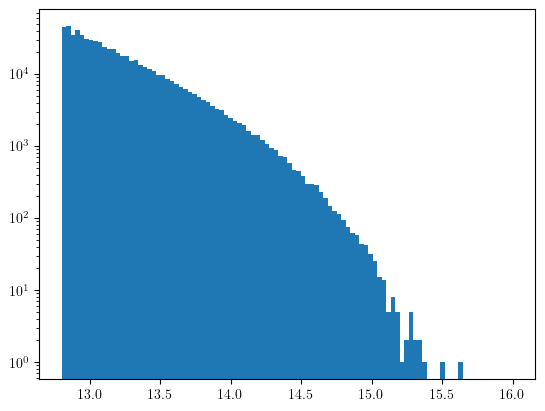

In [8]:
pl.figure()
_ = pl.hist(np.log10(mass_truth), range=(12.8, 16), bins=100)
pl.yscale('log')




In [ ]:
# FOR ROCKSTAR HALOS:

# root         = '/pscratch/sd/s/spandey/quijote/Snapshot_fid'
root = '/mnt/home/spandey/ceph/Quijote/fiducial_HR_new/Snapshots'
# snap_dir_base='/pscratch/sd/s/spandey/quijote/Halos/fiducial'
# mass_types = ['fof','rockstar_200c','rockstar_vir']
mass_types = ['rockstar_200c']
# mass_types = ['fof']
# Mmin_cut = 7e12
# Mmin_cut_str = '7e12'

Mmin_cut = 1e13
Mmin_cut_str = '1e13'

# root_out     = '/pscratch/sd/s/spandey/quijote/data_NGP_self'
root_out = '/mnt/home/spandey/ceph/Quijote/data_NGP_self'
ptypes       = [1]
# snapnum      = 0
# grids         = [64, 128, 256, 512]
# grids         = [64, 128, 256]
# grids         = [128]
grids         = [256]
BoxSize = 1000.0 #Mpc/h ; size of box
n_batch = 8
n_filter = 3
# n_cnn_all = [0,5,7]
# n_cnn_all = [8, 0]
# n_cnn_all = [2,4]
# n_cnn_all = [12,16]
n_cnn_all = [0]
# n_sim_tot = 2
# n_sim_array = np.arange(0,10)
# n_sim_array = np.arange(0,16)
n_sim_array = np.arange(0,1)
# snap_num_array = [-1,0,1,2,3,4]
# snap_num_array = [-1,4]
snap_num_array = [4]
# snap_num_array = [-1]
# i = 0
# print(i)
for mass_type in mass_types:
    print('doing mass type: ' + str(mass_type))
    for ji in n_sim_array:
        print('doing sim: ' + str(ji))
        for grid in grids:
            # print('doing res: ' + str(grid))
            for snapnum in snap_num_array:
                z = {4:0, 3:0.5, 2:1, 1:2, 0:3, -1: 127}[snapnum]

                # create output folder if it does not exists
                folder_out = '%s/%d'%(root_out,ji)
                if not(os.path.exists(folder_out)):
                    os.system('mkdir %s'%folder_out)

                
                savefname_halos_subvol = '%s/halos_HR_%s_lgMmincut_%s_subvol_res_%d_z=%s.pk'%(folder_out,mass_type,Mmin_cut_str,grid,z)
                savefname_halos_full = '%s/halos_HR_%s_lgMmincut_%s_full_res_%d_z=%s.pk'%(folder_out,mass_type,Mmin_cut_str,grid,z)            
                
                
                # savefname = folder_out  + '/halo_density_data_dict_' + str(grid) + '.pk'
                # if os.path.exists(fout):  continue

                # compute the density field and save it to file
                # if snapnum > 0:
                #     snapshot = '%s/%d/snapdir_%03d/snap_%03d'%(root,ji,snapnum,snapnum)
                # else:
                #     snapshot = '%s/%d/ICs/ics' % (root, ji)
                # df_cic = MASL.density_field_gadget(snapshot, ptypes, grid, MAS='CIC',
                #                                do_RSD=False, axis=0, verbose=True)
                # df_pylians_cic = df_cic/np.mean(df_cic, dtype=np.float64)-1.0
                
                
                # df_ngp = MASL.density_field_gadget(snapshot, ptypes, grid, MAS='NGP',
                #                                do_RSD=False, axis=0, verbose=True)
                # df_pylians_ngp = df_ngp/np.mean(df_ngp, dtype=np.float64)-1.0            
                
                if snapnum > 0:
                    if 'rockstar' in mass_type:
                        snap_dir_base = '/mnt/home/spandey/ceph/Quijote/fiducial_HR_new/Halos/Rockstar'
                        snapdir = snap_dir_base + '/' + str(ji)  #folder hosting the catalogue
                        rockstar = np.loadtxt(snapdir + '/out_' + str(snapnum) + '_pid.list')
                        with open(snapdir + '/out_' + str(snapnum) + '_pid.list', 'r') as f:
                            lines = f.readlines()
                        header = lines[0].split()
                        # get the properties of the halos
                        pos_h_truth = rockstar[:,header.index('X'):header.index('Z')+1]
                        if mass_type == 'rockstar_vir':
                            index_M = header.index('Mvir')                    
                            mass_truth = rockstar[:,index_M]  #Halo masses in Msun/h
                        if mass_type == 'rockstar_200c':
                            index_M = header.index('M200c')                    
                            mass_truth = rockstar[:,index_M]  #Halo masses in Msun/h
                    if 'fof' in mass_type:
                        snap_dir_base = '/mnt/home/spandey/ceph/Quijote/fiducial_HR_new/Halos/FoF'
                        snapdir = snap_dir_base + '/' + str(ji)  #folder hosting the catalogue
                        FoF = readfof.FoF_catalog(snapdir, snapnum, long_ids=False, swap=False, SFR=False, read_IDs=False)
                        # get the properties of the halos
                        pos_h_truth = FoF.GroupPos / 1e3  #Halo positions in Mpc/h
                        mass_truth = FoF.GroupMass * 1e10  #Halo masses in Msun/h

        
                    lgMass_truth = np.log10(mass_truth)
                    indsel = np.where(mass_truth > Mmin_cut)[0]
                    print(grid, len(indsel), len(mass_truth), np.amin(lgMass_truth), np.log10(Mmin_cut))
                    pos_h_truth = pos_h_truth[indsel]
                    lgMass_truth = lgMass_truth[indsel]

                    Nhalos = np.float32(np.zeros((grid, grid, grid)))
                    MASL.NGP(np.float32(pos_h_truth), Nhalos, BoxSize)
                    print('mass type: ', str(mass_type), ', max number of halos:', np.amax(Nhalos))

                    if grid == 64:
                        nMax_h = 30  # maximum number of halos expected in a cell
                    elif grid == 128:
                        nMax_h = 10
                    elif grid == 256:
                        nMax_h = 8
                    elif grid == 512:
                        nMax_h = 3
                    elif grid == 1024:
                        nMax_h = 2
                    else:
                        print('nside not supported')
                        sys.exit()

                    dfhalo_ngp_wmass = np.float32(np.zeros((grid, grid, grid, nMax_h)))
                    NGP_mass(np.float32(pos_h_truth), np.float32(lgMass_truth), dfhalo_ngp_wmass, BoxSize)


                    M_halos = np.flip(np.sort(dfhalo_ngp_wmass, axis=-1), axis=-1)


                    # now split it into nbatches each side

                    subvol_size = grid // n_batch
                    nsubvol = n_batch**3
                    save_subvol_Nhalo = np.zeros((nsubvol, subvol_size, subvol_size, subvol_size))
                    save_subvol_Mhalo = np.zeros((nsubvol, subvol_size, subvol_size, subvol_size, nMax_h))

                    jc = 0
                    from tqdm import tqdm
                    for jx in (range(n_batch)):
                        for jy in range(n_batch):
                            for jz in range(n_batch):
                                # get the sub-cube
                                save_subvol_Nhalo[jc] = Nhalos[jx * subvol_size:(jx + 1) * subvol_size,
                                                            jy * subvol_size:(jy + 1) * subvol_size,
                                                            jz * subvol_size:(jz + 1) * subvol_size]
                                save_subvol_Mhalo[jc] = M_halos[jx * subvol_size:(jx + 1) * subvol_size,
                                                                jy * subvol_size:(jy + 1) * subvol_size,
                                                                jz * subvol_size:(jz + 1) * subvol_size]
                                # save_subvol_density_cic_unpad[jc] = df_pylians_cic[jx * subvol_size:(jx + 1) * subvol_size,
                                #                                jy * subvol_size:(jy + 1) * subvol_size,
                                #                                jz * subvol_size:(jz + 1) * subvol_size]
                                # save_subvol_density_ngp_unpad[jc] = df_pylians_ngp[jx * subvol_size:(jx + 1) * subvol_size,
                                #                                jy * subvol_size:(jy + 1) * subvol_size,
                                #                                jz * subvol_size:(jz + 1) * subvol_size]                        
                                jc += 1

                    saved_halos_subvol = {
                        'N_halos': save_subvol_Nhalo,
                        'M_halos': save_subvol_Mhalo,
                        }    
                    # pk.dump(saved_halos_subvol, open(savefname_halos_subvol, 'wb'))

                    saved_halos_full = {
                        'N_halos_combined': Nhalos,
                        'M_halos_combined': M_halos,
                        }    
                    # pk.dump(saved_halos_full, open(savefname_halos_full, 'wb'))

Nhalos_256 = Nhalos
M_halos_256 = M_halos


In [ ]:
# FOR ROCKSTAR HALOS:

# root         = '/pscratch/sd/s/spandey/quijote/Snapshot_fid'
root = '/mnt/home/spandey/ceph/Quijote/fiducial_HR_new/Snapshots'
# snap_dir_base='/pscratch/sd/s/spandey/quijote/Halos/fiducial'
# mass_types = ['fof','rockstar_200c','rockstar_vir']
mass_types = ['rockstar_200c']
# mass_types = ['fof']
# Mmin_cut = 7e12
# Mmin_cut_str = '7e12'

Mmin_cut = 1e13
Mmin_cut_str = '1e13'

# root_out     = '/pscratch/sd/s/spandey/quijote/data_NGP_self'
root_out = '/mnt/home/spandey/ceph/Quijote/data_NGP_self'
ptypes       = [1]
# snapnum      = 0
# grids         = [64, 128, 256, 512]
# grids         = [64, 128, 256]
# grids         = [128]
grids         = [128]
BoxSize = 1000.0 #Mpc/h ; size of box
n_batch = 8
n_filter = 3
# n_cnn_all = [0,5,7]
# n_cnn_all = [8, 0]
# n_cnn_all = [2,4]
# n_cnn_all = [12,16]
n_cnn_all = [0]
# n_sim_tot = 2
# n_sim_array = np.arange(0,10)
# n_sim_array = np.arange(0,16)
n_sim_array = np.arange(0,1)
# snap_num_array = [-1,0,1,2,3,4]
# snap_num_array = [-1,4]
snap_num_array = [4]
# snap_num_array = [-1]
# i = 0
# print(i)
for mass_type in mass_types:
    print('doing mass type: ' + str(mass_type))
    for ji in n_sim_array:
        print('doing sim: ' + str(ji))
        for grid in grids:
            # print('doing res: ' + str(grid))
            for snapnum in snap_num_array:
                z = {4:0, 3:0.5, 2:1, 1:2, 0:3, -1: 127}[snapnum]

                # create output folder if it does not exists
                folder_out = '%s/%d'%(root_out,ji)
                if not(os.path.exists(folder_out)):
                    os.system('mkdir %s'%folder_out)

                
                savefname_halos_subvol = '%s/halos_HR_%s_lgMmincut_%s_subvol_res_%d_z=%s.pk'%(folder_out,mass_type,Mmin_cut_str,grid,z)
                savefname_halos_full = '%s/halos_HR_%s_lgMmincut_%s_full_res_%d_z=%s.pk'%(folder_out,mass_type,Mmin_cut_str,grid,z)            
                
                
                # savefname = folder_out  + '/halo_density_data_dict_' + str(grid) + '.pk'
                # if os.path.exists(fout):  continue

                # compute the density field and save it to file
                # if snapnum > 0:
                #     snapshot = '%s/%d/snapdir_%03d/snap_%03d'%(root,ji,snapnum,snapnum)
                # else:
                #     snapshot = '%s/%d/ICs/ics' % (root, ji)
                # df_cic = MASL.density_field_gadget(snapshot, ptypes, grid, MAS='CIC',
                #                                do_RSD=False, axis=0, verbose=True)
                # df_pylians_cic = df_cic/np.mean(df_cic, dtype=np.float64)-1.0
                
                
                # df_ngp = MASL.density_field_gadget(snapshot, ptypes, grid, MAS='NGP',
                #                                do_RSD=False, axis=0, verbose=True)
                # df_pylians_ngp = df_ngp/np.mean(df_ngp, dtype=np.float64)-1.0            
                
                if snapnum > 0:
                    if 'rockstar' in mass_type:
                        snap_dir_base = '/mnt/home/spandey/ceph/Quijote/fiducial_HR_new/Halos/Rockstar'
                        snapdir = snap_dir_base + '/' + str(ji)  #folder hosting the catalogue
                        rockstar = np.loadtxt(snapdir + '/out_' + str(snapnum) + '_pid.list')
                        with open(snapdir + '/out_' + str(snapnum) + '_pid.list', 'r') as f:
                            lines = f.readlines()
                        header = lines[0].split()
                        # get the properties of the halos
                        pos_h_truth = rockstar[:,header.index('X'):header.index('Z')+1]
                        if mass_type == 'rockstar_vir':
                            index_M = header.index('Mvir')                    
                            mass_truth = rockstar[:,index_M]  #Halo masses in Msun/h
                        if mass_type == 'rockstar_200c':
                            index_M = header.index('M200c')                    
                            mass_truth = rockstar[:,index_M]  #Halo masses in Msun/h
                    if 'fof' in mass_type:
                        snap_dir_base = '/mnt/home/spandey/ceph/Quijote/fiducial_HR_new/Halos/FoF'
                        snapdir = snap_dir_base + '/' + str(ji)  #folder hosting the catalogue
                        FoF = readfof.FoF_catalog(snapdir, snapnum, long_ids=False, swap=False, SFR=False, read_IDs=False)
                        # get the properties of the halos
                        pos_h_truth = FoF.GroupPos / 1e3  #Halo positions in Mpc/h
                        mass_truth = FoF.GroupMass * 1e10  #Halo masses in Msun/h

        
                    lgMass_truth = np.log10(mass_truth)
                    indsel = np.where(mass_truth > Mmin_cut)[0]
                    print(grid, len(indsel), len(mass_truth), np.amin(lgMass_truth), np.log10(Mmin_cut))
                    pos_h_truth = pos_h_truth[indsel]
                    lgMass_truth = lgMass_truth[indsel]

                    Nhalos = np.float32(np.zeros((grid, grid, grid)))
                    MASL.NGP(np.float32(pos_h_truth), Nhalos, BoxSize)
                    print('mass type: ', str(mass_type), ', max number of halos:', np.amax(Nhalos))

                    if grid == 64:
                        nMax_h = 30  # maximum number of halos expected in a cell
                    elif grid == 128:
                        nMax_h = 10
                    elif grid == 256:
                        nMax_h = 8
                    elif grid == 512:
                        nMax_h = 3
                    elif grid == 1024:
                        nMax_h = 2
                    else:
                        print('nside not supported')
                        sys.exit()

                    dfhalo_ngp_wmass = np.float32(np.zeros((grid, grid, grid, nMax_h)))
                    NGP_mass(np.float32(pos_h_truth), np.float32(lgMass_truth), dfhalo_ngp_wmass, BoxSize)


                    M_halos = np.flip(np.sort(dfhalo_ngp_wmass, axis=-1), axis=-1)


                    # now split it into nbatches each side

                    subvol_size = grid // n_batch
                    nsubvol = n_batch**3
                    save_subvol_Nhalo = np.zeros((nsubvol, subvol_size, subvol_size, subvol_size))
                    save_subvol_Mhalo = np.zeros((nsubvol, subvol_size, subvol_size, subvol_size, nMax_h))

                    jc = 0
                    from tqdm import tqdm
                    for jx in (range(n_batch)):
                        for jy in range(n_batch):
                            for jz in range(n_batch):
                                # get the sub-cube
                                save_subvol_Nhalo[jc] = Nhalos[jx * subvol_size:(jx + 1) * subvol_size,
                                                            jy * subvol_size:(jy + 1) * subvol_size,
                                                            jz * subvol_size:(jz + 1) * subvol_size]
                                save_subvol_Mhalo[jc] = M_halos[jx * subvol_size:(jx + 1) * subvol_size,
                                                                jy * subvol_size:(jy + 1) * subvol_size,
                                                                jz * subvol_size:(jz + 1) * subvol_size]
                                # save_subvol_density_cic_unpad[jc] = df_pylians_cic[jx * subvol_size:(jx + 1) * subvol_size,
                                #                                jy * subvol_size:(jy + 1) * subvol_size,
                                #                                jz * subvol_size:(jz + 1) * subvol_size]
                                # save_subvol_density_ngp_unpad[jc] = df_pylians_ngp[jx * subvol_size:(jx + 1) * subvol_size,
                                #                                jy * subvol_size:(jy + 1) * subvol_size,
                                #                                jz * subvol_size:(jz + 1) * subvol_size]                        
                                jc += 1

                    saved_halos_subvol = {
                        'N_halos': save_subvol_Nhalo,
                        'M_halos': save_subvol_Mhalo,
                        }    
                    # pk.dump(saved_halos_subvol, open(savefname_halos_subvol, 'wb'))

                    saved_halos_full = {
                        'N_halos_combined': Nhalos,
                        'M_halos_combined': M_halos,
                        }    
                    # pk.dump(saved_halos_full, open(savefname_halos_full, 'wb'))

Nhalos_128 = Nhalos
M_halos_128 = M_halos


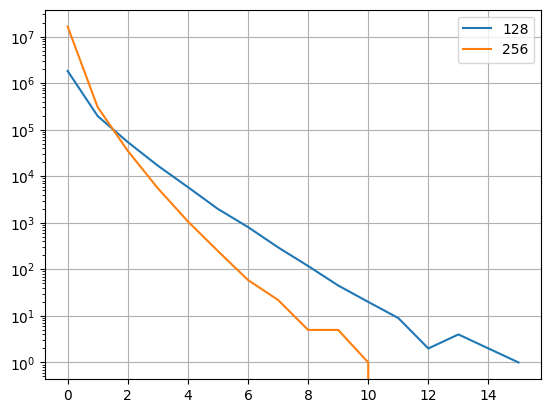

In [20]:
bin_edge_min = np.arange(-0.5, 15.5)
bin_edge_max = np.arange(0.5, 16.5)
bin_edges = np.arange(-0.5, 16.5)
bin_cents = 0.5*(bin_edge_min + bin_edge_max)

hist_Nhalos_128 = np.histogram(Nhalos_128.flatten(), bins=bin_edges)[0]
hist_Nhalos_256 = np.histogram(Nhalos_256.flatten(), bins=bin_edges)[0]
pl.figure()
# _ = pl.hist(Nhalos_128.flatten(), bins=20, range=(0,20))
# _ = pl.hist(Nhalos_256.flatten(), bins=20, range=(0,20), histtype='step')
pl.plot(bin_cents, hist_Nhalos_128, label='128')
pl.plot(bin_cents, hist_Nhalos_256, label='256')
pl.legend()
pl.yscale('log')
pl.grid()




In [17]:
np.arange(-0.5, 15.5)


array([-0.5,  0.5,  1.5,  2.5,  3.5,  4.5,  5.5,  6.5,  7.5,  8.5,  9.5,
       10.5, 11.5, 12.5, 13.5, 14.5])

In [ ]:
ji = 0
snapnum = 4
snap_dir_base = '/mnt/home/spandey/ceph/Quijote/fiducial_HR_new/Halos/Rockstar'
snapdir = snap_dir_base + '/' + str(ji)  #folder hosting the catalogue
rockstar = np.loadtxt(snapdir + '/out_' + str(snapnum) + '_pid.list')
with open(snapdir + '/out_' + str(snapnum) + '_pid.list', 'r') as f:
    lines = f.readlines()
header = lines[0].split()
# get the properties of the halos
pos_h_truth = rockstar[:,header.index('X'):header.index('Z')+1]
pos_h_truth.shape



In [ ]:
# pos_h_truth.shape
# data = df['density_cic_unpad_combined']
fig = pl.figure()
ax = fig.add_subplot(111, projection='3d')

# # Define the grid coordinates
# x, y, z = np.meshgrid(np.arange(data.shape[0]),
#                       np.arange(data.shape[1]),
#                       np.arange(data.shape[2]))

# # Flatten the grid coordinates and data for plotting
# x = x.flatten()
# y = y.flatten()
# z = z.flatten()
# values = data.flatten()

# Create a 3D matrix plot
ax.scatter(pos_h_truth[::100,0], pos_h_truth[::100,1], pos_h_truth[::100,2], s=0.05, c='k')
ax.grid(False)
ax.set_xticks([])
ax.set_yticks([])
ax.set_zticks([])
pl.savefig('halo_scatter.png',dpi=300,bbox_inches='tight')



In [ ]:
# root         = '/pscratch/sd/s/spandey/quijote/Snapshot_fid'
root = '/mnt/home/spandey/ceph/Quijote/fiducial_new/Snapshots'
# snap_dir_base='/pscratch/sd/s/spandey/quijote/Halos/fiducial'
mass_types = ['fof','rockstar_200c','rockstar_vir']
Mmin_cut = 5e13
Mmin_cut_str = '5e13'
# root_out     = '/pscratch/sd/s/spandey/quijote/data_NGP_self'
root_out = '/mnt/home/spandey/ceph/Quijote/data_NGP_self'
ptypes       = [1]
# snapnum      = 0
# grids         = [64, 128, 256, 512]
# grids         = [64, 128, 256]
grids         = [128]
BoxSize = 1000.0 #Mpc/h ; size of box
n_batch = 8
n_filter = 3
# n_cnn_all = [0,5,7]
# n_cnn_all = [8, 0]
n_cnn_all = [2,4]
# n_sim_tot = 2
# n_sim_array = np.arange(0,10)
n_sim_array = np.arange(0,50)
# snap_num_array = [-1,0,1,2,3,4]
# snap_num_array = [-1,4]
snap_num_array = [4]


In [ ]:
# if 'rockstar' in mass_type:
ji_array = np.arange(50)
from tqdm import tqdm
snapnum = 4
for ji in tqdm(ji_array):
    snap_dir_base = '/mnt/home/spandey/ceph/Quijote/fiducial_new/Halos/Rockstar'
    snapdir = snap_dir_base + '/' + str(ji)  #folder hosting the catalogue
    rockstar = np.loadtxt(snapdir + '/out_' + str(snapnum) + '_pid.list')
    with open(snapdir + '/out_' + str(snapnum) + '_pid.list', 'r') as f:
        lines = f.readlines()
    header = lines[0].split()

    index_M = header.index('Mvir')                    
    mass_truth_vir = rockstar[:,index_M]  #Halo masses in Msun/h
    if ji == 0:
        mass_truth_vir_all = mass_truth_vir
    else:
        mass_truth_vir_all = np.concatenate((mass_truth_vir_all,mass_truth_vir))

    index_M = header.index('M200c')                    
    mass_truth_200c = rockstar[:,index_M]  #Halo masses in Msun/h
    if ji == 0:
        mass_truth_200c_all = mass_truth_200c
    else:
        mass_truth_200c_all = np.concatenate((mass_truth_200c_all,mass_truth_200c))

    snap_dir_base = '/mnt/home/spandey/ceph/Quijote/fiducial_new/Halos/FoF'
    snapdir = snap_dir_base + '/' + str(ji)  #folder hosting the catalogue
    FoF = readfof.FoF_catalog(snapdir, snapnum, long_ids=False, swap=False, SFR=False, read_IDs=False)
    mass_truth_fof = FoF.GroupMass * 1e10  #Halo masses in Msun/h
    if ji == 0:
        mass_truth_fof_all = mass_truth_fof
    else:
        mass_truth_fof_all = np.concatenate((mass_truth_fof_all,mass_truth_fof))



In [ ]:
from colossus.cosmology import cosmology
import scipy as sp
params = {'flat': True, 'H0': 67.11, 'Om0': 0.3175, 'Ob0': 0.049, 'sigma8': 0.834, 'ns': 0.9624}
cosmo = cosmology.setCosmology('myCosmo', **params)
# get halo mass function:
from colossus.lss import mass_function

Mmin=np.log10(5e13)
Mmax=16.0
lgM_array = np.linspace(Mmin, Mmax, 1000)
M_array = 10**lgM_array
# if '200c' in mass_type:
hmfth_200c = mass_function.massFunction(M_array, 0, mdef = '200c', model = 'tinker08', q_out = 'dndlnM')
int_val = sp.integrate.simps(hmfth_200c, lgM_array)
hmfth_200c = hmfth_200c/int_val
# if 'vir' in mass_type:
hmfth_vir = mass_function.massFunction(M_array, 0, mdef = 'vir', model = 'tinker08', q_out = 'dndlnM')    
int_val = sp.integrate.simps(hmfth_vir, lgM_array)
hmfth_vir = hmfth_vir/int_val
# if 'fof' in mass_type:
hmfth_fof = mass_function.massFunction(M_array, 0, mdef = 'fof', model = 'bhattacharya11', q_out = 'dndlnM')
int_val = sp.integrate.simps(hmfth_fof, lgM_array)
hmfth_fof = hmfth_fof/int_val



In [ ]:
pl.figure()
_ = pl.hist(np.log10(mass_truth_vir_all), range=(Mmin,Mmax), density=True, bins=100, histtype='step', color='r', label='vir')
pl.plot(lgM_array, hmfth_vir, color='r')
_ = pl.hist(np.log10(mass_truth_200c_all), range=(Mmin,Mmax), density=True, bins=100, histtype='step', color='b', label='200c')
pl.plot(lgM_array, hmfth_200c, color='b')
_ = pl.hist(np.log10(mass_truth_fof_all), range=(Mmin,Mmax), density=True, bins=100, histtype='step', color='k', label='fof')
pl.plot(lgM_array, hmfth_fof, color='k')
# pl.axvline(np.log10(5e13), ls='--', color='k')
pl.yscale('log')
pl.legend()
pl.ylim(1e-6, 4)
pl.xlim(Mmin,Mmax)
pl.xlabel(r'$\log_{10} M_{\rm halo}$')
pl.ylabel(r'$dn/d\log_{10} M_{\rm halo}$')



In [ ]:
# if 'rockstar' in mass_type:
ji_array = np.arange(50)
from tqdm import tqdm
snapnum = 4
# for ji in tqdm(ji_array):
ji = 0
snap_dir_base = '/mnt/home/spandey/ceph/Quijote/fiducial_new/Halos/Rockstar'
snapdir = snap_dir_base + '/' + str(ji)  #folder hosting the catalogue
rockstar = np.loadtxt(snapdir + '/out_' + str(snapnum) + '_pid.list')
with open(snapdir + '/out_' + str(snapnum) + '_pid.list', 'r') as f:
    lines = f.readlines()
header = lines[0].split()

index_M = header.index('M200c')                    
mass_truth = rockstar[:,index_M]  #Halo masses in Msun/h
pos_h_truth = rockstar[:,header.index('X'):header.index('Z')+1]

lgMass_truth = np.log10(mass_truth)
indsel = np.where(mass_truth > Mmin_cut)[0]
pos_h_truth = pos_h_truth[indsel]
lgMass_truth = lgMass_truth[indsel]

Nhalos = np.float32(np.zeros((grid, grid, grid)))
MASL.NGP(np.float32(pos_h_truth), Nhalos, BoxSize)

if grid == 64:
    nMax_h = 30  # maximum number of halos expected in a cell
elif grid == 128:
    nMax_h = 10
elif grid == 256:
    nMax_h = 5
elif grid == 512:
    nMax_h = 3
elif grid == 1024:
    nMax_h = 2
else:
    print('nside not supported')
    sys.exit()

dfhalo_ngp_wmass = np.float32(np.zeros((grid, grid, grid, nMax_h)))
NGP_mass(np.float32(pos_h_truth), np.float32(lgMass_truth), dfhalo_ngp_wmass, BoxSize)


M_halos = np.flip(np.sort(dfhalo_ngp_wmass, axis=-1), axis=-1)

# now split it into nbatches each side

subvol_size = grid // n_batch
nsubvol = n_batch**3
save_subvol_Nhalo = np.zeros((nsubvol, subvol_size, subvol_size, subvol_size))
save_subvol_Mhalo = np.zeros((nsubvol, subvol_size, subvol_size, subvol_size, nMax_h))

jc = 0
from tqdm import tqdm
for jx in tqdm(range(n_batch)):
    for jy in range(n_batch):
        for jz in range(n_batch):
            # get the sub-cube
            save_subvol_Nhalo[jc] = Nhalos[jx * subvol_size:(jx + 1) * subvol_size,
                                            jy * subvol_size:(jy + 1) * subvol_size,
                                            jz * subvol_size:(jz + 1) * subvol_size]
            save_subvol_Mhalo[jc] = M_halos[jx * subvol_size:(jx + 1) * subvol_size,
                                            jy * subvol_size:(jy + 1) * subvol_size,
                                            jz * subvol_size:(jz + 1) * subvol_size]
            # save_subvol_density_cic_unpad[jc] = df_pylians_cic[jx * subvol_size:(jx + 1) * subvol_size,
            #                                jy * subvol_size:(jy + 1) * subvol_size,
            #                                jz * subvol_size:(jz + 1) * subvol_size]
            # save_subvol_density_ngp_unpad[jc] = df_pylians_ngp[jx * subvol_size:(jx + 1) * subvol_size,
            #                                jy * subvol_size:(jy + 1) * subvol_size,
            #                                jz * subvol_size:(jz + 1) * subvol_size]                        
            jc += 1



In [ ]:
indsel = np.where(save_subvol_Mhalo > 0)
save_subvol_Mhalo_pos = save_subvol_Mhalo[indsel]




In [ ]:
sdir = '/mnt/home/spandey/ceph/Quijote/data_NGP_self'
lgMmincutstr = '5e13'
nside_h = 128
mass_type = 'rockstar_200c'
fname = sdir + '/' + str(ji) + '/halos_' + mass_type + '_lgMmincut_' + lgMmincutstr + '_subvol_res_' + str(nside_h) + '_z=' + str(0) + '.pk'

df_h = pk.load(open(fname, 'rb'))
df_Mh_all = df_h['M_halos']
ind_pos = np.where(df_Mh_all > 0)
df_Mh_pos = df_Mh_all[ind_pos]


In [ ]:
pl.figure()
# _ = pl.hist(np.log10(mass_truth_vir_all), range=(Mmin,Mmax), density=True, bins=100, histtype='step', color='r', label='vir')
# pl.plot(lgM_array, hmfth_vir, color='r')
_ = pl.hist((save_subvol_Mhalo_pos), range=(Mmin,Mmax), density=True, bins=100, histtype='step', color='b', label='200c')
_ = pl.hist((df_Mh_pos), range=(Mmin,Mmax), density=True, bins=100, histtype='step', color='k', label='200c')
pl.plot(lgM_array, hmfth_200c, color='b')
# _ = pl.hist(np.log10(mass_truth_fof_all), range=(Mmin,Mmax), density=True, bins=100, histtype='step', color='k', label='fof')
# pl.plot(lgM_array, hmfth_fof, color='k')
# pl.axvline(np.log10(5e13), ls='--', color='k')
pl.yscale('log')
pl.legend()
pl.ylim(1e-6, 4)
pl.xlim(Mmin,Mmax)
pl.xlabel(r'$\log_{10} M_{\rm halo}$')
pl.ylabel(r'$dn/d\log_{10} M_{\rm halo}$')



In [ ]:
# test that all the histograms look like as expected:
ji = 1
grid = 128
snapnum = 4
z = {4:0, 3:0.5, 2:1, 1:2, 0:3}[snapnum]
df_halos_full = pk.load(open('/pscratch/sd/s/spandey/quijote/data_NGP_self/' + str(ji) + '/halos_full_res_'+ str(grid) + '_z=' + str(z) + '.pk','rb')) 
df_halos_subvol = pk.load(open('/pscratch/sd/s/spandey/quijote/data_NGP_self/' + str(ji) + '/halos_subvol_res_'+ str(grid) + '_z=' + str(z) + '.pk','rb')) 
df_density_full = pk.load(open('/pscratch/sd/s/spandey/quijote/data_NGP_self/' + str(ji) + '/density_full_m_res_'+ str(grid) + '_z=' + str(z) + '.pk','rb')) 
df_density_subvol = pk.load(open('/pscratch/sd/s/spandey/quijote/data_NGP_self/' + str(ji) + '/density_subvol_m_res_'+ str(grid) + '_z=' + str(z) + '.pk','rb')) 





In [ ]:
# df_pylians = df_density_full['density_cic_unpad_combined']
df_pylians = df_density_full['density_ngp_unpad_combined']
dfhalo2_ngp = df_halos_full['N_halos_combined']
dfhalo_ngp_wmass_sorted = df_halos_full['M_halos_combined']



In [ ]:
dfhalo2_ngp.shape, df_pylians.shape


In [ ]:
delta_min_p, delta_max_p = 10.5, 50.4
indsel_dp = np.where((df_pylians > delta_min_p) & (df_pylians < delta_max_p))
pl.figure(figsize=(8,6))
bin_cents = np.array([0,1,2,3,4,5,6,7,8])
bin_edges = 0.5*(bin_cents[1:] + bin_cents[:-1])
bin_edges = np.insert(bin_edges,0, -0.5)
bin_edges = np.insert(bin_edges,len(bin_edges), bin_cents[-1] + 0.5)
hist_truth, _ = np.histogram(dfhalo2_ngp[indsel_dp].flatten(), bins=bin_edges)
# _ = pl.hist(df_Nh_truth[indsel_dp].flatten(), histtype='step', bins=[0,1,2,3,4,5,6,7,8], label='Truth')
pl.plot(bin_cents, hist_truth, marker='s', color='k', ls='--', label='Truth')
# hist_samp, _ = np.histogram(Nhalos_truth_recomb[indsel_dp].flatten(), bins=bin_edges)
# _ = pl.hist(, bins=[0,1,2,3,4,5,6,7,8], label='Sampled')
# pl.plot(bin_cents, hist_samp, marker='o', color='b', ls='-', label='Sampled')
pl.yscale('log')
pl.legend(fontsize=15, frameon=False)
pl.tick_params(axis='both', which='major', labelsize=15)
pl.tick_params(axis='both', which='minor', labelsize=15)
pl.xlabel(r'$N_{\rm halo}$', size=18)
pl.ylabel('Histogram', size=18)
pl.title(str(delta_min_p) + r'$< \delta_m < $' + str(delta_max_p), size=18)




In [ ]:
fig, axes = pl.subplots(nrows=1, ncols=3, figsize=(18, 8), sharex=True, sharey=True)
fig.subplots_adjust(wspace=0.1, hspace=0.1)

# axes[0].imshow(((mesh_truth.preview(axes=[0,1]))))
# axes[0].set_title('Truth', size=18)
xmin = 0
xmax = 100
axes[0].imshow(df_pylians[64,:,:], vmin=0, vmax=8, origin='lower')
axes[0].set_title('Density', size=18)
axes[0].set_xlim(xmin,xmax)
axes[0].set_ylim(xmin,xmax)

axes[1].imshow(dfhalo2_ngp[64,:,:], vmin=0, vmax=8, origin='lower')
axes[1].set_title('Number', size=18)
axes[1].set_xlim(xmin,xmax)
axes[1].set_ylim(xmin,xmax)

# axes[2].imshow((np.abs(10**M_halos_truth_recomb[64,:,:,0] - 10**M_halos[64,:,:,0])/10**M_halos_truth_recomb[64,:,:,0]), vmin=0, vmax=1.0, origin='lower')
axes[2].imshow(dfhalo_ngp_wmass_sorted[64,:,:, 0], vmin=13, vmax=16, origin='lower')
axes[2].set_title('Heaviest Halo Mass', size=18)
axes[2].set_xlim(xmin,xmax)
axes[2].set_ylim(xmin,xmax)





            


In [ ]:
bin_edges = np.linspace(13, 16, 100)
bin_cents = 0.5*(bin_edges[1:] + bin_edges[:-1])


pl.figure(figsize=(8,6))
delta_min_p, delta_max_p = -1.0, -0.5
indsel_dp = np.where((df_pylians > delta_min_p) & (df_pylians < delta_max_p))
hist_truth, _ = np.histogram(dfhalo_ngp_wmass_sorted[...,0][indsel_dp].flatten(), bins=bin_edges, density=True)
pl.plot(bin_cents, hist_truth, marker='s', color='r', ls='--', label=str(delta_min_p) + r'$ < \delta <$' + str(delta_max_p))

delta_min_p, delta_max_p = 0.0, 0.5
indsel_dp = np.where((df_pylians > delta_min_p) & (df_pylians < delta_max_p))
hist_truth, _ = np.histogram(dfhalo_ngp_wmass_sorted[...,0][indsel_dp].flatten(), bins=bin_edges, density=True)
pl.plot(bin_cents, hist_truth, marker='s', color='b', ls='--', label=str(delta_min_p) + r'$ < \delta <$' + str(delta_max_p))


delta_min_p, delta_max_p = 1.0, 50.0
indsel_dp = np.where((df_pylians > delta_min_p) & (df_pylians < delta_max_p))
hist_truth, _ = np.histogram(dfhalo_ngp_wmass_sorted[...,0][indsel_dp].flatten(), bins=bin_edges, density=True)
pl.plot(bin_cents, hist_truth, marker='s', color='k', ls='--', label=str(delta_min_p) + r'$ < \delta <$' + str(delta_max_p))


pl.yscale('log')
pl.legend(fontsize=15, frameon=False)
pl.tick_params(axis='both', which='major', labelsize=15)
pl.tick_params(axis='both', which='minor', labelsize=15)
pl.xlabel(r'$\log_{10}(M_{0})$', size=15)
pl.ylabel('Histogram Density', size=16)
# pl.title(str(delta_min_p) + r'$< \delta_m < $' + str(delta_max_p), size=18)




In [ ]:
bin_edges = np.linspace(13, 16, 100)
bin_cents = 0.5*(bin_edges[1:] + bin_edges[:-1])


pl.figure(figsize=(8,6))
delta_min_p, delta_max_p = 1.0, 50.0
indsel_dp = np.where((df_pylians > delta_min_p) & (df_pylians < delta_max_p))
hist_truth, _ = np.histogram(dfhalo_ngp_wmass_sorted[...,0][indsel_dp].flatten(), bins=bin_edges, density=True)
pl.plot(bin_cents, hist_truth, marker='s', color='r', ls='--', label=r'$\log_{10}(M_0)$')

hist_truth, _ = np.histogram(dfhalo_ngp_wmass_sorted[...,1][indsel_dp].flatten(), bins=bin_edges, density=True)
pl.plot(bin_cents, hist_truth, marker='s', color='b', ls='--', label=r'$\log_{10}(M_1)$')

hist_truth, _ = np.histogram(dfhalo_ngp_wmass_sorted[...,2][indsel_dp].flatten(), bins=bin_edges, density=True)
pl.plot(bin_cents, hist_truth, marker='s', color='k', ls='--', label=r'$\log_{10}(M_2)$')


pl.yscale('log')
pl.legend(fontsize=15, frameon=False)
pl.tick_params(axis='both', which='major', labelsize=15)
pl.tick_params(axis='both', which='minor', labelsize=15)
pl.xlabel(r'$\log_{10}(M_{\rm halo})$', size=15)
pl.ylabel('Histogram Density', size=16)
pl.title(str(delta_min_p) + r'$< \delta_m < $' + str(delta_max_p), size=18)




In [ ]:
pl.figure(figsize=(8,6))
delta_min_p, delta_max_p = -1.0, 50.0
indsel_dp = np.where((df_pylians > delta_min_p) & (df_pylians < delta_max_p))
density_list = df_pylians[indsel_dp].flatten()
logM_list = dfhalo_ngp_wmass_sorted[...,0][indsel_dp].flatten()
indsel_rand = np.random.randint(0, len(density_list), np.amin(np.array([len(density_list), 100000])))
pl.scatter(np.log(1+density_list[indsel_rand]),logM_list[indsel_rand], s=0.1)
# pl.xscale('log')
pl.tick_params(axis='both', which='major', labelsize=15)
pl.tick_params(axis='both', which='minor', labelsize=15)
pl.ylim(13, 16)
pl.xlim(-1,3)
pl.xlabel(r'$\log(1 + \delta)$', size=16)
pl.ylabel(r'$\log_{10}(M_{0})$', size=16)

# pl.xlim(delta_min_p-0.1, delta_max_p)




In [ ]:
save_subvol_density_pad = df_density_subvol['density_ngp_pad']
save_subvol_density_unpad = df_density_subvol['density_ngp_unpad']
save_subvol_Nhalo = df_halos_subvol['N_halos']
save_subvol_Mhalo = df_halos_subvol['M_halos']



In [ ]:
fig, axes = pl.subplots(nrows=1, ncols=4, figsize=(24, 8))
fig.subplots_adjust(wspace=0.1, hspace=0.1)

# axes[0].imshow(((mesh_truth.preview(axes=[0,1]))))
# axes[0].set_title('Truth', size=18)
xmin = 0
xmax = 15
axes[0].imshow(save_subvol_density_unpad[0,8,...], vmin=0, vmax=8, origin='lower')
axes[0].set_title('Density unpadded', size=18)
axes[0].set_xlim(xmin,xmax)
axes[0].set_ylim(xmin,xmax)
axes[0].tick_params(axis='both', which='major', labelsize=15)
axes[0].tick_params(axis='both', which='minor', labelsize=15)


axes[1].imshow(save_subvol_density_pad[0, n_pad + 8,...], vmin=0, vmax=8, origin='lower')
axes[1].set_title('Density padded', size=18)
# axes[1].set_xlim(xmin+n_pad,xmax+n_pad)
# axes[1].set_ylim(xmin+n_pad,xmax+n_pad)
axes[1].tick_params(axis='both', which='major', labelsize=15)
axes[1].tick_params(axis='both', which='minor', labelsize=15)


# axes[2].imshow((np.abs(10**M_halos_truth_recomb[64,:,:,0] - 10**M_halos[64,:,:,0])/10**M_halos_truth_recomb[64,:,:,0]), vmin=0, vmax=1.0, origin='lower')
axes[2].imshow(save_subvol_Nhalo[0,8,...], vmin=0, vmax=5, origin='lower')
axes[2].set_title('Number', size=18)
axes[2].set_xlim(xmin,xmax)
axes[2].set_ylim(xmin,xmax)
axes[2].tick_params(axis='both', which='major', labelsize=15)
axes[2].tick_params(axis='both', which='minor', labelsize=15)


axes[3].imshow(save_subvol_Mhalo[..., 0][0,8,...], vmin=13, vmax=16, origin='lower')
axes[3].set_title('Heaviest Halo Mass', size=18)
axes[3].set_xlim(xmin,xmax)
axes[3].set_ylim(xmin,xmax)
axes[3].tick_params(axis='both', which='major', labelsize=15)
axes[3].tick_params(axis='both', which='minor', labelsize=15)





            





In [5]:
ji = 1
grid = 128
snapnum = 4
z = {4:0, 3:0.5, 2:1, 1:2, 0:3, -1:127}[snapnum]
df_halos_full_z0 = pk.load(open('/mnt/home/spandey/ceph/Quijote/data_NGP_self/' + str(ji) + '/halos_HR_rockstar_200c_lgMmincut_1e13_full_res_128_z=0.pk','rb')) 
df_density_full_z0 = pk.load(open('/mnt/home/spandey/ceph/Quijote/data_NGP_self/' + str(ji) + '/density_HR_full_m_res_128_z=0_nbatch_8_nfilter_3_ncnn_0.pk','rb')) 


In [6]:
df_density_full_z127 = pk.load(open('/mnt/home/spandey/ceph/Quijote/data_NGP_self/' + str(ji) + '/density_HR_full_m_res_128_z=127_nbatch_8_nfilter_3_ncnn_0.pk','rb')) 


In [9]:
rhom_IC = df_density_full_z127['density_ngp_unpad_combined']
rhom_z0 = df_density_full_z0['density_ngp_unpad_combined']



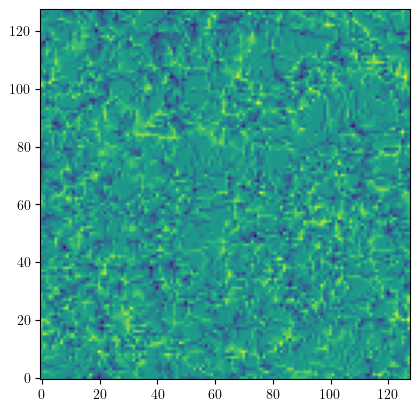

In [12]:
pl.figure()
pl.imshow(np.log(np.abs(1 + rhom_IC[64,:,:])), origin='lower')


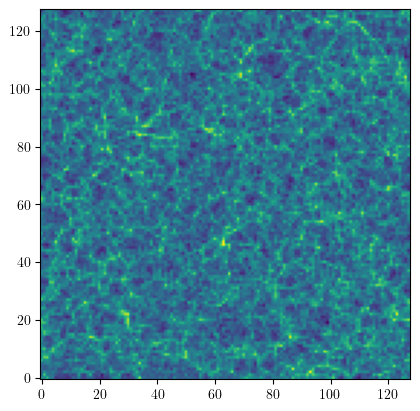

In [13]:
pl.figure()
pl.imshow(np.log(np.abs(1 + rhom_z0[64,:,:])), origin='lower')


In [17]:
# ji_array = np.arange(50)
from tqdm import tqdm
snapnum = 4
# for ji in tqdm(ji_array):
ji = 0
snap_dir_base = '/mnt/home/spandey/ceph/Quijote/fiducial_new/Halos/Rockstar'
snapdir = snap_dir_base + '/' + str(ji)  #folder hosting the catalogue
rockstar = np.loadtxt(snapdir + '/out_' + str(snapnum) + '_pid.list')
with open(snapdir + '/out_' + str(snapnum) + '_pid.list', 'r') as f:
    lines = f.readlines()
header = lines[0].split()

index_M = header.index('M200c')                    
mass_truth = rockstar[:,index_M]  #Halo masses in Msun/h
pos_h_truth = rockstar[:,header.index('X'):header.index('Z')+1]


In [22]:
# pos_h_truth
# np.amax(pos_h_truth)
ind_all = np.arange(len(pos_h_truth))
ind_rand = np.random.randint(0, len(pos_h_truth), 10000)


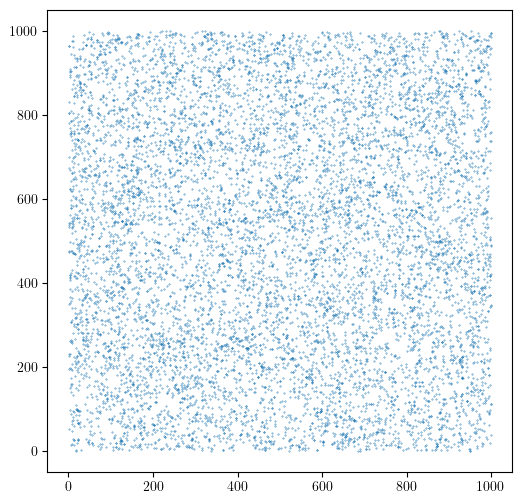

In [24]:
pl.figure(figsize=(6,6))
pl.scatter(pos_h_truth[ind_rand,0], pos_h_truth[ind_rand,1], s=0.1)
